## Experiment 2
- ASTER dems
- using processed outputs from ragmac_xdem/scripts/main_experiment2.py
- these dems are all already aligned, but can add check and reproject as needed, e.g. https://github.com/GlacioHack/geoprofile/blob/main/geoprofile/core/core.py#L122

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import xdem
import geoutils as gu
import numpy as np
import datetime
import psutil
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from ragmac_xdem import utils, temporal

In [11]:
input_dir = '../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs'
dem_fn_list = glob.glob(os.path.join(input_dir, 'DEM*.tif'))
dem_fn_list.sort()

In [12]:
len(dem_fn_list)

119

In [13]:
arrays = []
# dt_list_decyear = []

for fn in dem_fn_list:
    src = gu.georaster.Raster(fn)  
    arrays.append(src.data)
    # decyear = float(os.path.basename(fn).split('_')[1])
    # dt_list_decyear.append(decyear)

In [14]:
ma_stack = np.ma.vstack(arrays)

In [15]:
ma_stack.shape

(119, 3176, 3878)

In [16]:
# dt_list = [tools.convert_decimal_date_to_date_time(i)[0] for i in dt_list_decyear]
dt_list = utils.get_dems_date(dem_fn_list)

In [17]:
common_mask = np.ma.getmaskarray(ma_stack).all(axis=0)

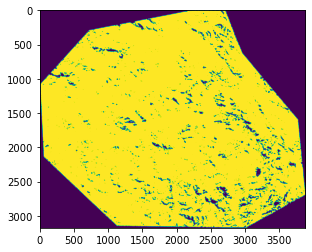

In [18]:
plt.imshow(~common_mask)

### Per-pixel linear regression

github issue: https://github.com/adehecq/ragmac_xdem/issues/8

```
Write a function that takes a stack of DEMs on the same grid (i.e. a 3D masked array) and returns fit parameters of a temporal regression.
Example based on David's code: https://github.com/dshean/pygeotools/blob/9c8d7d5cff5f4fd1c08cf2d46dd1566d229ae9ad/pygeotools/lib/malib.py#L999

Additionally, write a function that takes the fit parameters and returns the elevation of all pixels at any given time within the valid time range.
```


### Prepare test dataset

In [19]:
#ma_stack_test = ma_stack[:, 1000:1032, 1000:1032]
stride = 20
ma_stack_test = ma_stack[:, ::stride, ::stride]

In [20]:
ma_stack_test.shape

(119, 159, 194)

In [21]:
def plot_ma_linreg_3panel(results):
    m, b, m_detr = results
    f, axa = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 3), dpi=150)
    clim_perc = (5, 95)
    _m = axa[0].imshow(m, cmap='RdBu', clim=temporal.calcperc_sym(m, clim_perc))
    f.colorbar(_m, ax=axa[0])
    _m = axa[1].imshow(b, cmap='viridis', clim=temporal.calcperc(b))
    f.colorbar(_m, ax=axa[1])
    _m = axa[2].imshow(m_detr, cmap='inferno', clim=temporal.calcperc(m_detr, (0,95)))
    f.colorbar(_m, ax=axa[2])

    for ax in axa:
        ax.set_xticks(())
        ax.set_yticks(())

In [22]:
def plot_ma_linreg(results):
    m, b, m_detr = results
    f, ax = plt.subplots(dpi=150)
    clim_perc = (5, 95)
    _m = ax.imshow(m, cmap='RdBu', clim=temporal.calcperc_sym(m, clim_perc))
    f.colorbar(_m, ax=ax)
    ax.set_xticks(())
    ax.set_yticks(())

In [23]:
%%time
"""
Modifications to malib.ma_linreg transposed to temporal.py
# use matplitlib.dates.date2num directly to convert time stamps
# use psutils to check for logical cores
# add aux functions from malib.py 
 - mad()
 - checkma()
"""

results = temporal.ma_linreg(ma_stack_test, 
                          dt_list, 
                          n_thresh=3, 
                          model='theilsen', 
                          dt_stack_ptp=None, 
                          min_dt_ptp=None, 
                          smooth=False,
                          rsq=False, 
                          conf_test=False, 
                          parallel=True, 
                          n_cpu=None, 
                          remove_outliers=False)

Excluding pixels with count < 3
Iteration #1
21535 valid pixels with up to 119 timestamps: 519142 total valid samples
Running in parallel with 7 processes


Fitting temporal trend: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21535/21535 [00:37<00:00, 574.80it/s]


Computing residuals
CPU times: user 6.6 s, sys: 2.76 s, total: 9.37 s
Wall time: 40.3 s


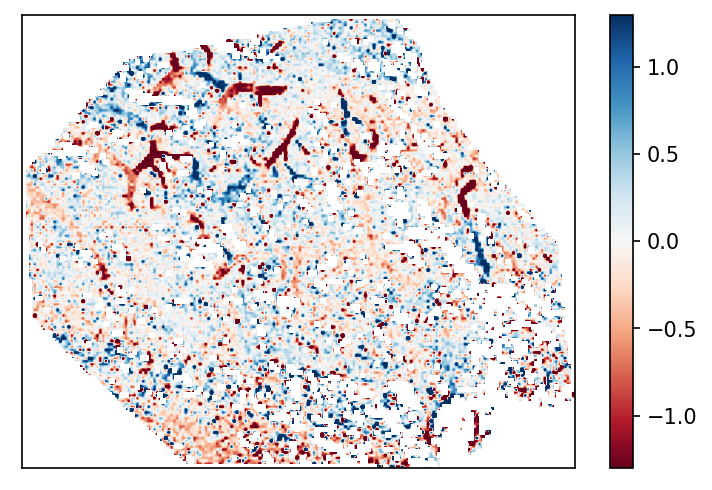

In [24]:
plot_ma_linreg(results)

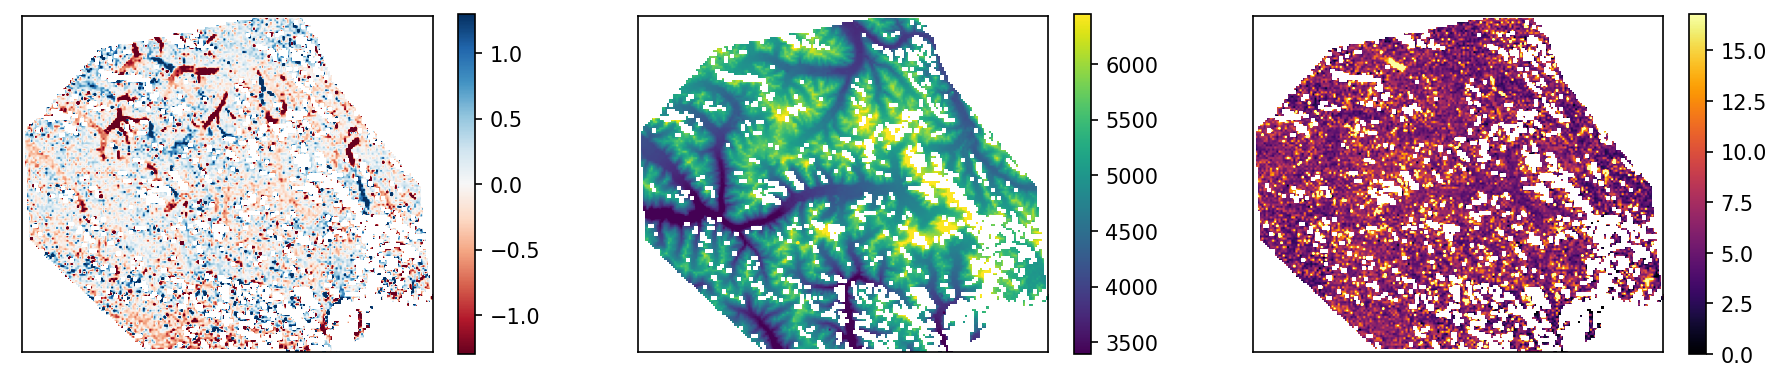

In [25]:
plot_ma_linreg_3panel(results)

## To do
* Filter outliers
* Smoothing
* Add multiprocessing for other robust linear fit appraoches (Romain, Amaury)
* Extrapolate/interpolate to arbitrary dates
* Test for shorter periods between target dates